# This notebook is meant to draw all the plots regarding ddPCM paper

___

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
# A function that reads .fmm and .dense output files
def read_output_file(fname):
    # Init output dict
    result = {}
    # Read entire file in a single shot
    with open(fname, "r") as fd:
        lines = fd.readlines()
    # Number of atoms
    natoms = int(lines[18].split()[0])
    result["natoms"] = natoms
    #print(natoms)
    # Find start of output
    iline = 0
    while(lines[iline] != "=====OUTPUT=====\n"):
        #print(iline, lines[iline])
        iline += 1
    # Read time of mkrhs
    iline += 2
    result["mkrhs time"] = float(lines[iline].split()[2])
    # Cycle through iterations of the ddPCM system
    iline += 1
    while(lines[iline][:5] != "ddpcm"):
        #print(iline, lines[iline])
        iline += 1
    result["ddpcm step time"] = float(lines[iline].split()[3])
    iline += 1
    result["ddpcm step niter"] = int(lines[iline].split()[3])
    # Cycle through iterations of the ddCOSMO system
    iline += 1
    while(lines[iline][:7] != "ddcosmo"):
        #print(iline, lines[iline])
        iline += 1
    result["ddcosmo step time"] = float(lines[iline].split()[3])
    iline += 1
    result["ddcosmo step niter"] = int(lines[iline].split()[3])
    # Cycle through iterations of the adjoint ddCOSMO system
    iline += 1
    while(lines[iline][:7] != "adjoint"):
        #print(iline, lines[iline])
        iline += 1
    result["adjoint ddcosmo step time"] = float(lines[iline].split()[4])
    iline += 1
    result["adjoint ddcosmo step niter"] = int(lines[iline].split()[4])
    # Cycle through iterations of the adjoint ddPCM system
    iline += 1
    while(lines[iline][:7] != "adjoint"):
        #print(iline, lines[iline])
        iline += 1
    result["adjoint ddpcm step time"] = float(lines[iline].split()[4])
    iline += 1
    result["adjoint ddpcm step niter"] = int(lines[iline].split()[4])
    # Total ddPCM time
    iline += 1
    result["ddpcm time"] = float(lines[iline].split()[2])
    iline += 1
    result["ddpcm esolv"] = float(lines[iline].split()[2])
    # Forces
    iline += 2
    forces = np.zeros((natoms, 3))
    for i in range(natoms):
        forces[i] = list(map(float, lines[iline].split()[1:]))
        iline += 1
    result["ddpcm forces"] = forces
    return result

___

## 1. Comparison of a dense ddPCM solver against FMM ddPCM solver
 
- Maximal degree of modeling spherical harmonics:
    - lmax=6,8,10,12
- Maximal degree of the FMM spherical harmonics:
    - pm=pl=pmax=40 
- Number of Lebedev grid points:
    - ngrid=590

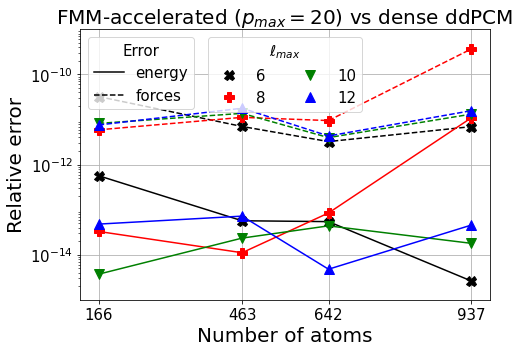

In [3]:
# Plot dense vs fmm accuracy for lmax=6, 8, 10 and 12
lmaxs = [6, 8, 10, 12]
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas"]
natoms = [166, 463, 642, 937]
styles = {6: {"color": "black", "marker": "X", "markersize": 10},
          8: {"color": "red", "marker": "P", "markersize": 10},
          10: {"color": "green", "marker": "v", "markersize": 10},
          12: {"color": "blue", "marker": "^", "markersize": 10}}
# Create a figure
fig, ax = plt.subplots(figsize=(7, 5))
legend1_handles = []
# Add plots to the figure
for lmax in lmaxs:
    rel_err_esolv = []
    rel_err_forces = []
    for mol in molecules:
        fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.20.fmm".format(mol, lmax)
        #print("Read:", fname_fmm)
        result_fmm = read_output_file(fname_fmm)
        fname_dense = "../experiments/dense_vs_fmm_sas/{}.{}.dense".format(mol, lmax)
        #print("Read:", fname_dense)
        result_dense = read_output_file(fname_dense)
        rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_dense["ddpcm esolv"]) /
                            result_dense["ddpcm esolv"]))
        rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_dense["ddpcm forces"]) /
                            np.linalg.norm(result_dense["ddpcm forces"]))
    #print(rel_err_esolv)
    #print(rel_err_forces)
    ax.semilogy(natoms, rel_err_esolv, label="{}".format(lmax),
                linestyle="-", **styles[lmax])
    ax.semilogy(natoms, rel_err_forces, label="{}".format(lmax),
                linestyle="dashed", **styles[lmax])
    legend1_handles.append(Line2D([], [], label="{}".format(lmax), linestyle="", **styles[lmax]))
ax.grid()
ax.set_xticks(natoms)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim([1e-15, 1e-9])
ax.set_yticks([1e-10, 1e-12, 1e-14])
ax.set_title("FMM-accelerated ($p_{{max}}=20$) vs dense ddPCM", fontsize=20)
ax.set_xlabel("Number of atoms", fontsize=20)
ax.set_ylabel("Relative error", fontsize=20)
#ax.legend(loc="upper left", ncol=2, fontsize=15).set_title("$\ell_{{max}}$", prop={"size": 15})
legend1 = plt.legend(handles=legend1_handles, loc="upper center", ncol=2, fontsize=15)
legend1.set_title("$\ell_{{max}}$", prop={"size": 15})
legend2_handles = [Line2D([], [], linestyle="-", color="black", label="energy"),
                  Line2D([], [], linestyle="dashed", color="black", label="forces")]
legend2 = plt.legend(handles=legend2_handles, loc="upper left", ncol=1, fontsize=15)
legend2.set_title("Error", prop={"size": 15})
ax.add_artist(legend1)
fig.tight_layout()
#plt.savefig("dense_vs_fmm_sas_error.pdf")
plt.savefig("dense_vs_fmm_sas_error.pgf")
plt.show()
plt.close()

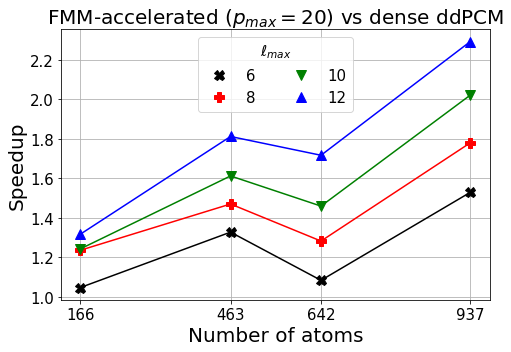

In [4]:
# Plot dense vs fmm time for lmax=6, 8, 10 and 12
lmaxs = [6, 8, 10, 12]
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas"]
natoms = [166, 463, 642, 937]
styles = {6: {"color": "black", "marker": "X", "markersize": 10},
          8: {"color": "red", "marker": "P", "markersize": 10},
          10: {"color": "green", "marker": "v", "markersize": 10},
          12: {"color": "blue", "marker": "^", "markersize": 10}}
# Create a figure
fig, ax = plt.subplots(figsize=(7, 5))
legend1_handles = []
# Add plots to the figure
for lmax in lmaxs:
    speedup = []
    for mol in molecules:
        fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.20.fmm".format(mol, lmax)
        #print("Read:", fname_fmm)
        result_fmm = read_output_file(fname_fmm)
        fname_dense = "../experiments/dense_vs_fmm_sas/{}.{}.dense".format(mol, lmax)
        #print("Read:", fname_dense)
        result_dense = read_output_file(fname_dense)
        speedup.append(result_dense["ddpcm time"] / result_fmm["ddpcm time"])
    ax.plot(natoms, speedup, linestyle="-", **styles[lmax])
    legend1_handles.append(Line2D([], [], label="{}".format(lmax), linestyle="", **styles[lmax]))
ax.grid()
ax.set_xticks(natoms)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#ax.set_ylim([1e-16, 1e-8])
ax.set_title("FMM-accelerated ($p_{{max}}=20$) vs dense ddPCM", fontsize=20)
ax.set_xlabel("Number of atoms", fontsize=20)
ax.set_ylabel("Speedup", fontsize=20)
#ax.legend(loc="upper left", ncol=2)
legend1 = plt.legend(handles=legend1_handles, loc="upper center", ncol=2, fontsize=15)
legend1.set_title("$\ell_{{max}}$", prop={"size": 15})
fig.tight_layout()
#plt.savefig("dense_vs_fmm_sas_speedup.pdf")
plt.savefig("dense_vs_fmm_sas_speedup.pgf")
plt.show()
plt.close()

___

## 2. Comparison of a FMM solver against FMM(pmax=20) ddPCM solver

Different maximal degree of modeling spherical harmonics correspond to different pmax values:
- lmax=6
    - pmax=0, 2, 4, 5, 6, 7, 8, 10, 12, 15
- lmax=8
    - pmax=0, 2, 4, 6, 7, 8, 9, 10, 12, 15
- lmax=10
    - pmax=0, 2, 4, 6, 8, 9, 10, 11, 12, 15
- lmax=12
    - pmax=0, 3, 6, 8, 10, 11, 12, 13, 14, 16

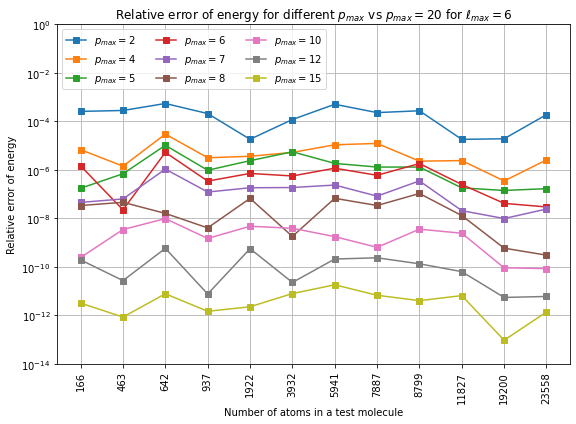

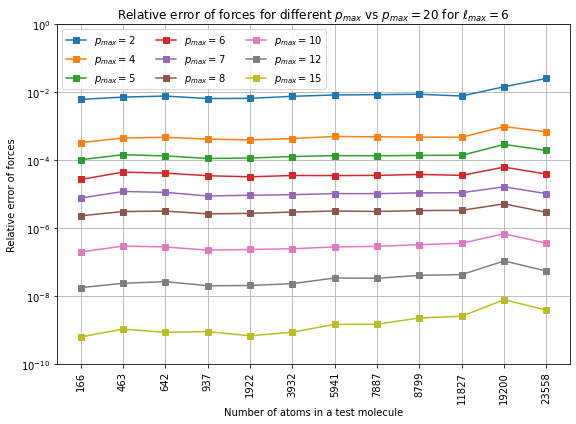

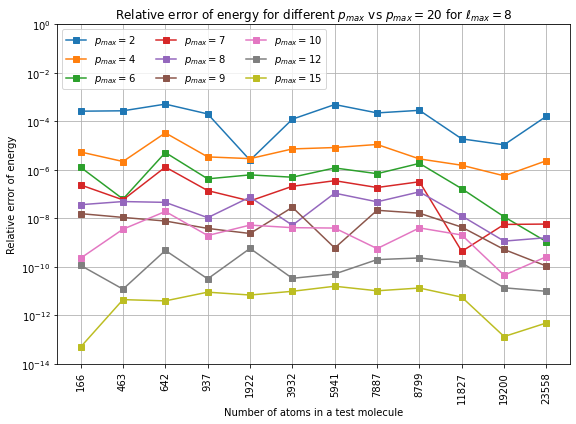

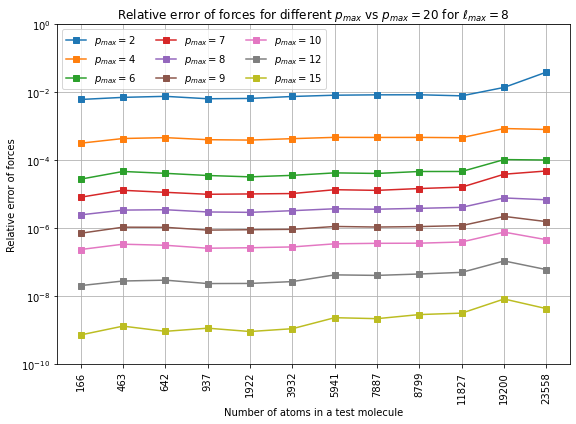

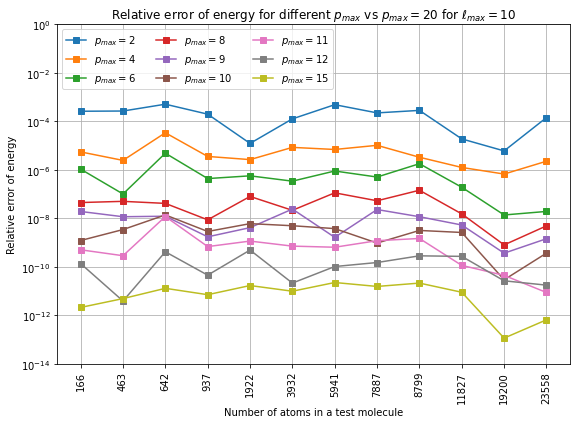

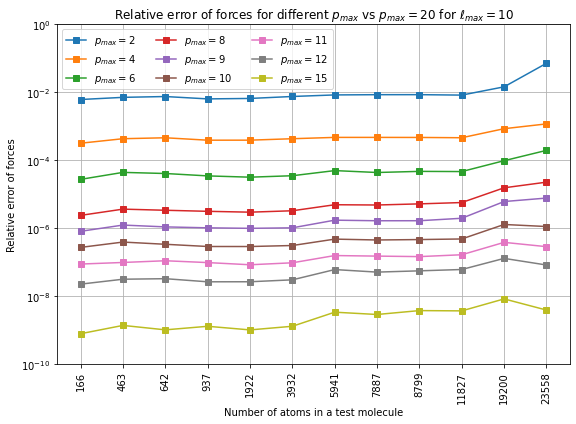

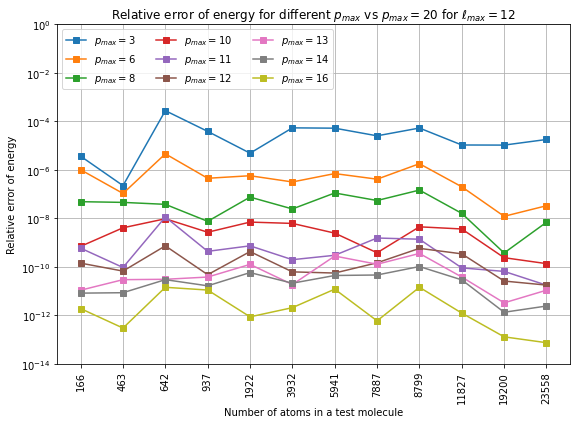

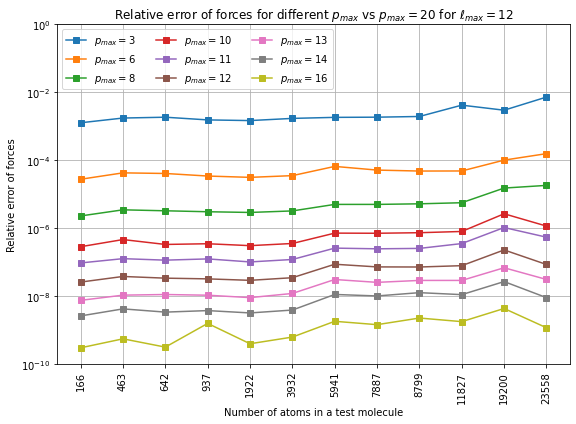

In [6]:
# Plot fmm vs fmm results for lmax=6, 8, 10 and 12 in different plots
lmaxs = [6, 8, 10, 12]
# Possible values of pmax for every lmax
pmaxs = {6: [2, 4, 5, 6, 7, 8, 10, 12, 15],
         8: [2, 4, 6, 7, 8, 9, 10, 12, 15],
         10: [2, 4, 6, 8, 9, 10, 11, 12, 15],
         12: [3, 6, 8, 10, 11, 12, 13, 14, 16]}
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterglobe_sas", "dhfr_sas"]
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 19200, 23558])
xticks = range(len(natoms))
# One plot for each lmax
for lmax in lmaxs:
    # Read data for pmax=20
    result_fmm20 = {}
    for mol in molecules:
        fname_fmm20 = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, 20)
        result_fmm20[mol] = read_output_file(fname_fmm20)
    # Create figure
    fig_esolv, ax_esolv = plt.subplots(figsize=(8,6))
    ax_esolv.grid()
    ax_esolv.set_xticks(xticks)
    ax_esolv.set_xticklabels(natoms, rotation="vertical")
    ax_esolv.set_xlabel("Number of atoms in a test molecule")
    ax_esolv.set_ylim([1e-14, 1e+0])
    ax_esolv.set_title("Relative error of energy for different $p_{{max}}$ vs $p_{{max}}=20$ for $\ell_{{max}}={}$".format(lmax))
    ax_esolv.set_ylabel("Relative error of energy")
    fig_esolv.tight_layout()
    fig_force, ax_force = plt.subplots(figsize=(8,6))
    ax_force.grid()
    ax_force.set_xticks(xticks)
    ax_force.set_xticklabels(natoms, rotation="vertical")
    ax_force.set_xlabel("Number of atoms in a test molecule")
    ax_force.set_ylim([1e-10, 1e+0])
    ax_force.set_title("Relative error of forces for different $p_{{max}}$ vs $p_{{max}}=20$ for $\ell_{{max}}={}$".format(lmax))
    ax_force.set_ylabel("Relative error of forces")
    fig_force.tight_layout()
    # Draw plots on error of energy and forces
    for pmax in pmaxs[lmax]:
        rel_err_esolv = []
        rel_err_forces = []
        for mol in molecules:
            # Read file with a given pmax
            fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
            result_fmm = read_output_file(fname_fmm)
            # Generate data to plot
            rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_fmm20[mol]["ddpcm esolv"]) /
                                result_fmm20[mol]["ddpcm esolv"]))
            rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_fmm20[mol]["ddpcm forces"]) /
                                np.linalg.norm(result_fmm20[mol]["ddpcm forces"]))
        ax_esolv.semilogy(xticks, rel_err_esolv, label="$p_{{max}}={}$".format(pmax), markersize=6, marker="s")
        ax_force.semilogy(xticks, rel_err_forces, label="$p_{{max}}={}$".format(pmax), markersize=6, marker="s")
   # Add legend
    ax_esolv.legend(loc="upper left", ncol=3)
    ax_force.legend(loc="upper left", ncol=3)
    #fig_esolv.savefig("fmm_vs_fmm_sas_esolv_{}.pdf".format(lmax))
    #fig_esolv.savefig("fmm_vs_fmm_sas_esolv_{}.pgf".format(lmax))
    #fig_force.savefig("fmm_vs_fmm_sas_force_{}.pdf".format(lmax))
    #fig_force.savefig("fmm_vs_fmm_sas_force_{}.pgf".format(lmax))
    plt.show()
    plt.close()

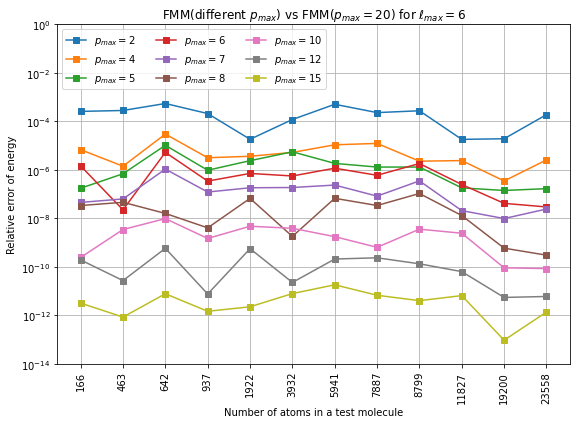

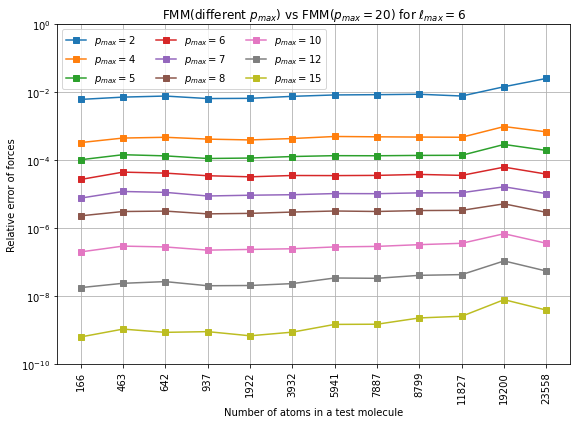

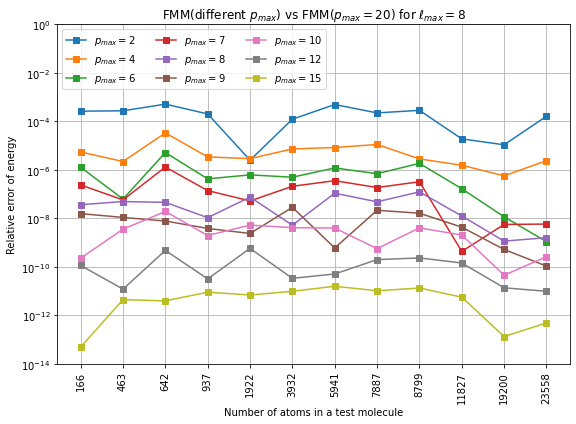

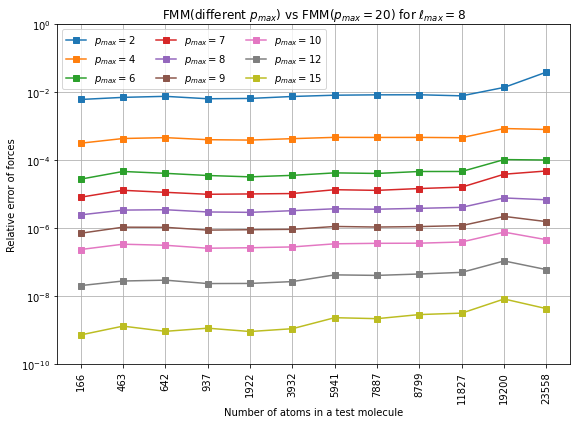

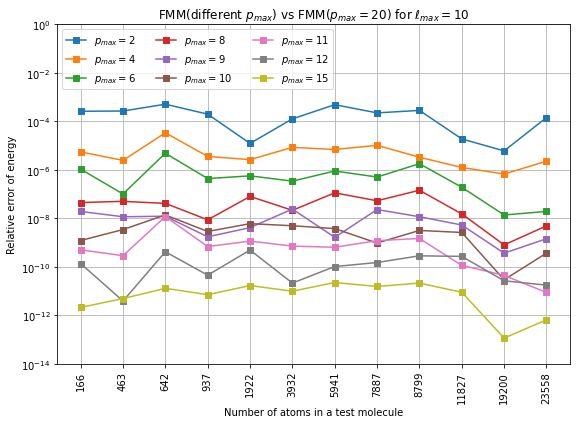

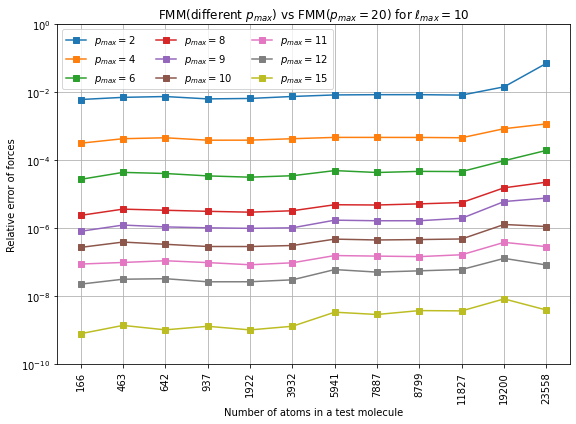

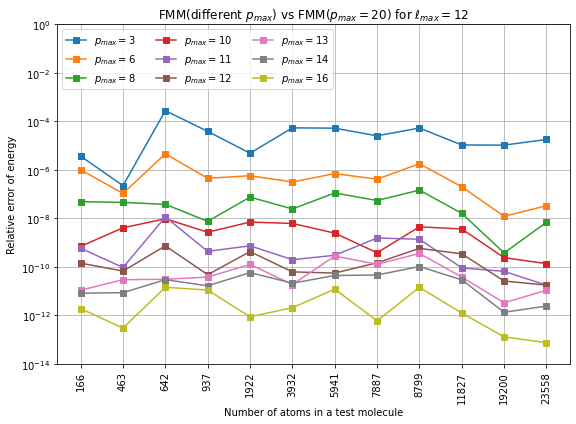

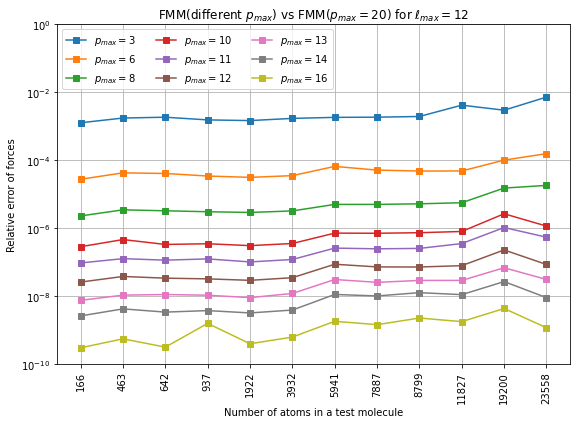

In [7]:
# Plot fmm vs fmm results for lmax=6, 8, 10 and 12 in different plots
lmaxs = [6, 8, 10, 12]
# Possible values of pmax for every lmax
pmaxs = {6: [2, 4, 5, 6, 7, 8, 10, 12, 15],
         8: [2, 4, 6, 7, 8, 9, 10, 12, 15],
         10: [2, 4, 6, 8, 9, 10, 11, 12, 15],
         12: [3, 6, 8, 10, 11, 12, 13, 14, 16]}
# Values of pmax to show in scaling
pmaxs_scale1 = {6: [2, 6, 10],
         8: [2, 8, 12],
         10: [2, 10, 15],
         12: [3, 12, 16]}
pmaxs_scale2 = {6: [6],
         8: [8],
         10: [10],
         12: [12]}
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterglobe_sas", "dhfr_sas"]
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 19200, 23558])
xticks = range(len(natoms))
# One plot for each lmax
for lmax in lmaxs:
    # Read data for pmax=20
    result_fmm20 = {}
    for mol in molecules:
        fname_fmm20 = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, 20)
        result_fmm20[mol] = read_output_file(fname_fmm20)
    # Create figure
    fig_esolv, ax_esolv = plt.subplots(figsize=(8,6))
    ax_esolv.grid()
    ax_esolv.set_xticks(xticks)
    ax_esolv.set_xticklabels(natoms, rotation="vertical")
    ax_esolv.set_xlabel("Number of atoms in a test molecule")
    ax_esolv.set_ylim([1e-14, 1e+0])
    ax_esolv.set_title("FMM(different $p_{{max}}$) vs FMM($p_{{max}}=20$) for $\ell_{{max}}={}$".format(lmax))
    ax_esolv.set_ylabel("Relative error of energy")
    fig_esolv.tight_layout()
    fig_force, ax_force = plt.subplots(figsize=(8,6))
    ax_force.grid()
    ax_force.set_xticks(xticks)
    ax_force.set_xticklabels(natoms, rotation="vertical")
    ax_force.set_xlabel("Number of atoms in a test molecule")
    ax_force.set_ylim([1e-10, 1e+0])
    ax_force.set_title("FMM(different $p_{{max}}$) vs FMM($p_{{max}}=20$) for $\ell_{{max}}={}$".format(lmax))
    ax_force.set_ylabel("Relative error of forces")
    fig_force.tight_layout()
#     fig_time, ax_time = plt.subplots(figsize=(8,6))
#     ax_time.grid()
#     ax_time.set_xticks(xticks)
#     ax_time.set_xticklabels([])
#     ax_time.set_xlabel("Number of atoms in a test molecule")
#     ax_time.set_title("FMM(different $p_{{max}}$) for $\ell_{{max}}={}$".format(lmax))
#     ax_time.set_ylabel("Total time (PCM+COSMO parts), seconds")
#     fig_time2, ax_time2 = plt.subplots(figsize=(8,6))
#     ax_time2.grid()
#     ax_time2.set_xticks(xticks)
#     ax_time2.set_xticklabels([])
#     ax_time2.set_xlabel("Number of atoms in a test molecule")
#     ax_time2.set_title("FMM(different $p_{{max}}$) for $\ell_{{max}}={}$".format(lmax))
#     ax_time2.set_ylabel("PCM vs COSMO time, seconds")
    # Draw plots on error of energy and forces
    for pmax in pmaxs[lmax]:
        rel_err_esolv = []
        rel_err_forces = []
#         total_time = []
#         pcm_time = []
#         cosmo_time = []
        for mol in molecules:
            # Read file with a given pmax
            fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
            result_fmm = read_output_file(fname_fmm)
            # Generate data to plot
            rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_fmm20[mol]["ddpcm esolv"]) /
                                result_fmm20[mol]["ddpcm esolv"]))
            rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_fmm20[mol]["ddpcm forces"]) /
                                np.linalg.norm(result_fmm20[mol]["ddpcm forces"]))
#             total_time.append(result_fmm["ddpcm time"])
#             cosmo_time.append(result_fmm["ddcosmo step time"] + result_fmm["adjoint ddcosmo step time"])
#             pcm_time.append(total_time[-1] - cosmo_time[-1])
        ax_esolv.semilogy(xticks, rel_err_esolv, label="$p_{{max}}={}$".format(pmax), markersize=6, marker="s")
        ax_force.semilogy(xticks, rel_err_forces, label="$p_{{max}}={}$".format(pmax), markersize=6, marker="s")
#         if pmax in pmaxs_scale1[lmax]:
#             ax_time.plot(natoms, total_time, label="$p_{{max}}={}$".format(pmax), markersize=6, marker="s")
#         if pmax in pmaxs_scale2[lmax]:
#             ax_time2.loglog(natoms, pcm_time, label="PCM part, $p_{{max}}={}$".format(pmax), markersize=6, marker="s")
    # Add pmax=20 plot
#     total_time20 = []
#     pcm_time20 = []
#     cosmo_time20 = []
#     for mol in molecules:
#         total_time20.append(result_fmm20[mol]["ddpcm time"])
#         cosmo_time20.append(result_fmm20[mol]["ddcosmo step time"]
#                           + result_fmm20[mol]["adjoint ddcosmo step time"])
#         pcm_time20.append(total_time20[-1] - cosmo_time20[-1])
#     total_time20 = np.array(total_time20)
#     pcm_time20 = np.array(pcm_time20)
#     cosmo_time20 = np.array(cosmo_time20)
    #ax_time.loglog(natoms, total_time20, label="$p_{{max}}={}$".format(20), markersize=6, marker="s")
    #ax_time2.loglog(natoms, pcm_time20, label="PCM part, pmax={}".format(20), markersize=6, marker="s")
    # Add cosmo time to a plot with pcm timing
    #ax_time2.loglog(natoms, cosmo_time, label="COSMO part", markersize=6, marker="s")
    # Add a trend line
    #ax_time2.loglog(natoms, natoms*np.log(natoms), label="$O(N \\log N)$ trend")
    # Add legend
    ax_esolv.legend(loc="upper left", ncol=3)
    ax_force.legend(loc="upper left", ncol=3)
    #ax_time.legend(loc="upper left", ncol=1)
    #ax_time2.legend(loc="upper left", ncol=1)
    #fig_esolv.savefig("fmm_vs_fmm_sas_esolv_{}.pdf".format(lmax))
    #fig_force.savefig("fmm_vs_fmm_sas_force_{}.pdf".format(lmax))
    ##fig_time.savefig("fmm_vs_fmm_sas_time_{}.pdf".format(lmax))
    ##fig_time2.savefig("fmm_vs_fmm_sas_time2_{}.pdf".format(lmax))
    plt.show()
    plt.close()

___

## 3. Comparison of accuracies of pmax=6, 8, 10 and 12 for different lmax

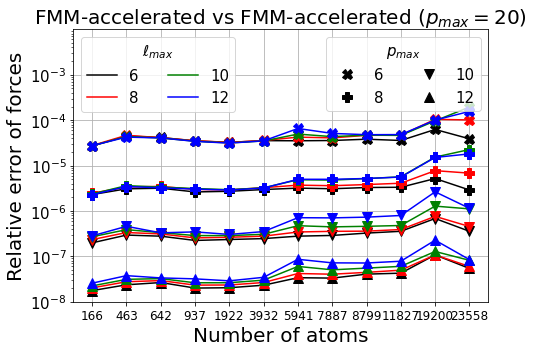

In [8]:
# Plot fmm (pmax=6,8,10,12) vs fmm (pmax=20) results for different lmax
pmaxs = [6, 8, 10, 12]
lmaxs = [6, 8, 10, 12]
# Style for markers for different pmax
marker_pmax = {6: {"marker": "X", "markersize": 10},
               8: {"marker": "P", "markersize": 10},
               10: {"marker": "v", "markersize": 10},
               12: {"marker": "^", "markersize": 10}}
# Style for different lmax
styles = {6: {"color": "black"},
          8: {"color": "red"},
          10: {"color": "green"},
          12: {"color": "blue"}}
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterglobe_sas", "dhfr_sas"]
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 19200, 23558])
xticks = range(len(natoms))
# Single figure with all the plots
fig, ax = plt.subplots(figsize=(7, 5))
# Handle for legend data
legend1_handles=[]
for lmax in lmaxs:
    # Create a proxy line to add to the legend
    line = Line2D([], [], label="{}".format(lmax), linestyle="-", **styles[lmax])
    legend1_handles.append(line)
    # Add plots for each possible value of pmax
    for pmax in pmaxs:
        rel_err_forces = []
        for mol in molecules:
            fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
            #print("Read:", fname_fmm)
            result_fmm = read_output_file(fname_fmm)
            fname_dense = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, 20)
            #print("Read:", fname_dense)
            result_dense = read_output_file(fname_dense)
            rel_err_forces.append(np.linalg.norm(result_fmm["ddpcm forces"]-result_dense["ddpcm forces"]) /
                                np.linalg.norm(result_dense["ddpcm forces"]))
        ax.semilogy(xticks, rel_err_forces, linestyle="-", **(styles[lmax] | marker_pmax[pmax]))
# Append legend data for different pmax
legend2_handles = []
for pmax in pmaxs:
    # Create a proxy line to add to the legend
    line = Line2D([], [], label="{}".format(pmax), linestyle="", color="black", **marker_pmax[pmax])
    legend2_handles.append(line)
# Finally draw the plot and augment it with proper data
ax.grid()
ax.set_xticks(xticks)
ax.set_xticklabels(natoms)
ax.set_ylim([1e-8, 1e-2])
ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
ax.set_title("FMM-accelerated vs FMM-accelerated ($p_{{max}}=20$)", fontsize=20)
ax.set_xlabel("Number of atoms", fontsize=20)
ax.set_ylabel("Relative error of forces", fontsize=20)
legend1 = plt.legend(handles=legend1_handles, loc="upper left", ncol=2, fontsize=15)
legend1.set_title("$\ell_{{max}}$", prop={"size": 15})
legend2 = plt.legend(handles=legend2_handles, loc="upper right", ncol=2, fontsize=15)
legend2.set_title("$p_{{max}}$", prop={"size": 15})
ax.add_artist(legend1)
fig.tight_layout()
#plt.savefig("fmm_vs_fmm_sas_force.pdf")
plt.savefig("fmm_vs_fmm_sas_force.pgf")
plt.show()
plt.close()

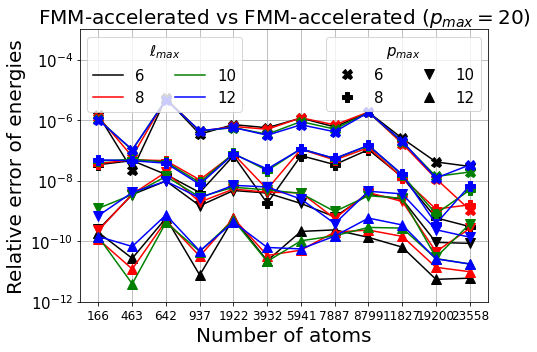

In [9]:
# Plot fmm (pmax=6,8,10,12) vs fmm (pmax=20) results for different lmax
pmaxs = [6, 8, 10, 12]
lmaxs = [6, 8, 10, 12]
# Style for different pmax
marker_pmax = {6: {"marker": "X", "markersize": 10},
               8: {"marker": "P", "markersize": 10},
               10: {"marker": "v", "markersize": 10},
               12: {"marker": "^", "markersize": 10}}
# Style for different lmax
styles = {6: {"color": "black"},
          8: {"color": "red"},
          10: {"color": "green"},
          12: {"color": "blue"}}
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterglobe_sas", "dhfr_sas"]
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 19200, 23558])
xticks = range(len(natoms))
# Single figure with all the plots
fig, ax = plt.subplots(figsize=(7, 5))
# Handle for legend data
legend1_handles=[]
for lmax in lmaxs:
    # Create a proxy line to add to the legend
    line = Line2D([], [], label="{}".format(lmax), linestyle="-", **styles[lmax])
    legend1_handles.append(line)
    # Add plots for each possible value of pmax
    for pmax in pmaxs:
        rel_err_esolv = []
        for mol in molecules:
            fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
            #print("Read:", fname_fmm)
            result_fmm = read_output_file(fname_fmm)
            fname_dense = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, 20)
            #print("Read:", fname_dense)
            result_dense = read_output_file(fname_dense)
            rel_err_esolv.append(abs((result_fmm["ddpcm esolv"]-result_dense["ddpcm esolv"]) /
                                result_dense["ddpcm esolv"]))
        ax.semilogy(xticks, rel_err_esolv, linestyle="-", **(styles[lmax] | marker_pmax[pmax]))
# Append legend data for different pmax
legend2_handles = []
for pmax in pmaxs:
    # Create a proxy line to add to the legend
    line = Line2D([], [], label="{}".format(pmax), linestyle="", color="black", **marker_pmax[pmax])
    legend2_handles.append(line)
# Finally draw the plot and augment it with proper data
ax.grid()
ax.set_xticks(xticks)
ax.set_xticklabels(natoms)
ax.set_ylim([1e-12, 1e-3])
ax.set_yticks([1e-12, 1e-10, 1e-8, 1e-6, 1e-4])
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
ax.set_title("FMM-accelerated vs FMM-accelerated ($p_{{max}}=20$)", fontsize=20)
ax.set_xlabel("Number of atoms", fontsize=20)
ax.set_ylabel("Relative error of energies", fontsize=20)
legend1 = plt.legend(handles=legend1_handles, loc="upper left", ncol=2, fontsize=15)
legend1.set_title("$\ell_{{max}}$", prop={"size": 15})
legend2 = plt.legend(handles=legend2_handles, loc="upper right", ncol=2, fontsize=15)
legend2.set_title("$p_{{max}}$", prop={"size": 15})
ax.add_artist(legend1)
fig.tight_layout()
#plt.savefig("fmm_vs_fmm_sas_esolv.pdf")
plt.savefig("fmm_vs_fmm_sas_esolv.pgf")
plt.show()
plt.close()

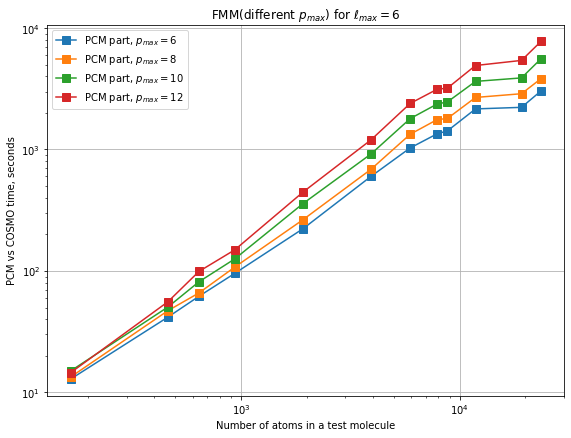

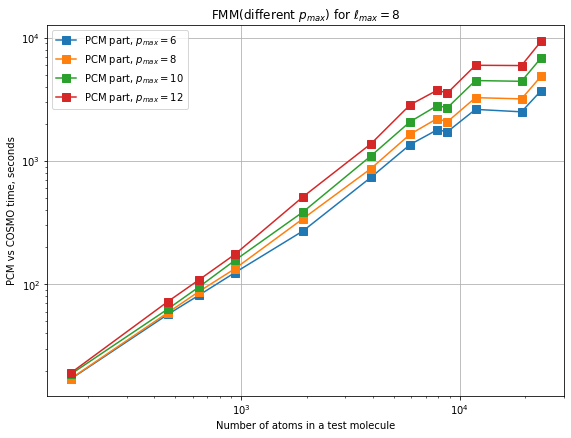

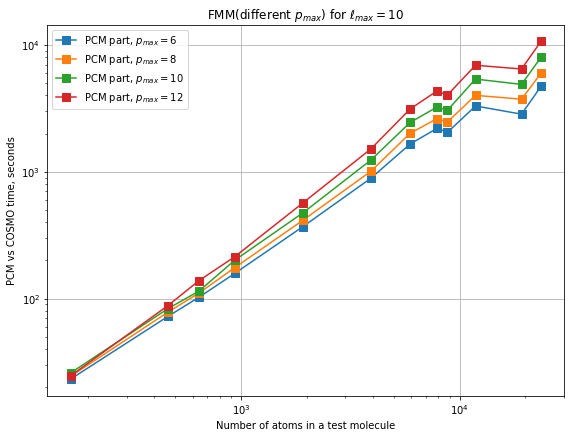

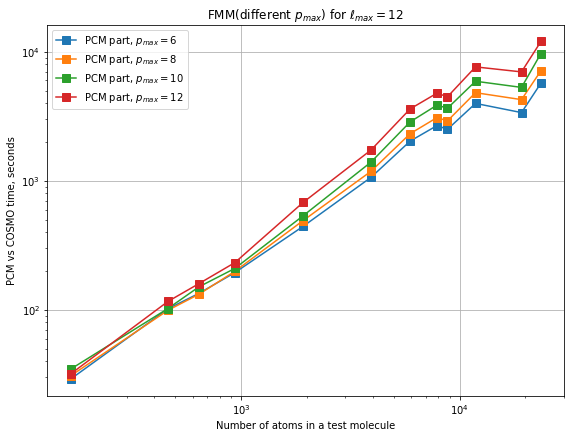

In [10]:
# Scaling of the fmm code
# Plot fmm vs fmm results for lmax=6, 8, 10 and 12 in different plots
lmaxs = [6, 8, 10, 12]
# Possible values of pmax for every lmax
pmaxs = {6: [2, 4, 5, 6, 7, 8, 10, 12, 15],
         8: [2, 4, 6, 7, 8, 9, 10, 12, 15],
         10: [2, 4, 6, 8, 9, 10, 11, 12, 15],
         12: [3, 6, 8, 10, 11, 12, 13, 14, 16]}
# Values of pmax to show in scaling
pmaxs_scale1 = {6: [6, 8, 10, 12],
         8: [6, 8, 10, 12],
         10: [6, 8, 10, 12],
         12: [6, 8, 10, 12]}
pmaxs_scale2 = pmaxs_scale1
# List output molecules in a proper order (increasing number of atoms)
molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterglobe_sas", "dhfr_sas"]
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 19200, 23558])
xticks = range(len(natoms))
# One plot for each lmax
for lmax in lmaxs:
    # Read data for pmax=20
    result_fmm20 = {}
    for mol in molecules:
        fname_fmm20 = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, 20)
        result_fmm20[mol] = read_output_file(fname_fmm20)
    # Create figure
#     fig_time, ax_time = plt.subplots(figsize=(8,6))
#     ax_time.grid()
#     ax_time.set_xticks(xticks)
#     ax_time.set_xticklabels([])
#     ax_time.set_xlabel("Number of atoms in a test molecule")
#     ax_time.set_title("FMM(different $p_{{max}}$) for $\ell_{{max}}={}$".format(lmax))
#     ax_time.set_ylabel("Total time (PCM+COSMO parts), seconds")
#     fig_time.tight_layout()
    fig_time2, ax_time2 = plt.subplots(figsize=(8,6))
    ax_time2.grid()
    ax_time2.set_xticks(xticks)
    ax_time2.set_xticklabels([])
    ax_time2.set_xlabel("Number of atoms in a test molecule")
    ax_time2.set_title("FMM(different $p_{{max}}$) for $\ell_{{max}}={}$".format(lmax))
    ax_time2.set_ylabel("PCM vs COSMO time, seconds")
    fig_time2.tight_layout()
    # Draw plots on error of energy and forces
    for pmax in pmaxs[lmax]:
        total_time = []
        pcm_time = []
        cosmo_time = []
        for mol in molecules:
            # Read file with a given pmax
            fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
            result_fmm = read_output_file(fname_fmm)
            # Generate data to plot
            total_time.append(result_fmm["ddpcm time"])
            cosmo_time.append(result_fmm["ddcosmo step time"] + result_fmm["adjoint ddcosmo step time"])
            pcm_time.append(total_time[-1] - cosmo_time[-1])
#         if pmax in pmaxs_scale1[lmax]:
#             ax_time.loglog(natoms, total_time, label="$p_{{max}}={}$".format(pmax), markersize=6, marker="s")
        if pmax in pmaxs_scale2[lmax]:
            ax_time2.loglog(natoms, pcm_time, label="PCM part, $p_{{max}}={}$".format(pmax), markersize=8, marker="s")
#     # Add pmax=20 plot
#     total_time20 = []
#     pcm_time20 = []
#     cosmo_time20 = []
#     for mol in molecules:
#         total_time20.append(result_fmm20[mol]["ddpcm time"])
#         cosmo_time20.append(result_fmm20[mol]["ddcosmo step time"]
#                           + result_fmm20[mol]["adjoint ddcosmo step time"])
#         pcm_time20.append(total_time20[-1] - cosmo_time20[-1])
#     total_time20 = np.array(total_time20)
#     pcm_time20 = np.array(pcm_time20)
#     cosmo_time20 = np.array(cosmo_time20)
#     ax_time.loglog(natoms, total_time20, label="$p_{{max}}={}$".format(20), markersize=6, marker="s")
#     ax_time2.loglog(natoms, pcm_time20, label="PCM part, $p_{{max}}={}$".format(20), markersize=6, marker="s")
    # Add cosmo time to a plot with pcm timing
    #ax_time2.loglog(natoms, cosmo_time, label="COSMO part", markersize=6, marker="s")
    # Add a trend line
    #ax_time2.loglog(natoms, natoms*np.log(natoms), label="$O(N \\log N)$ trend")
    # Add legend
#     ax_time.legend(loc="upper left", ncol=1)
    ax_time2.legend(loc="upper left", ncol=1)
#     fig_time.savefig("fmm_vs_fmm_sas_time_{}.pdf".format(lmax))
#    fig_time2.savefig("fmm_vs_fmm_sas_time2_{}.pdf".format(lmax))
    plt.show()
    plt.close()

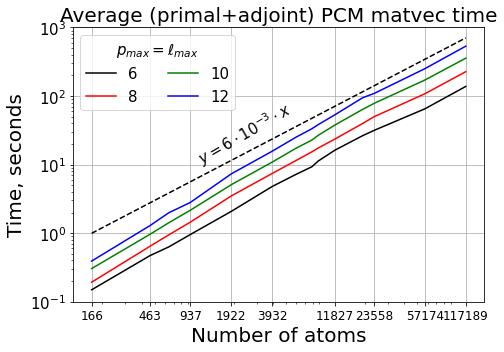

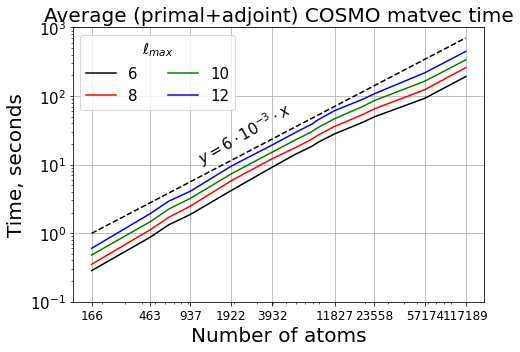

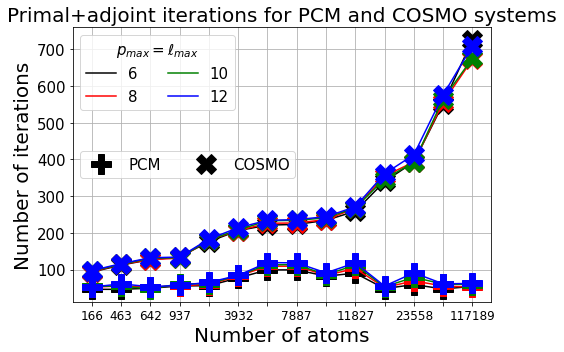

In [11]:
# Average performance of a single matvec for large scale runs with pmax=lmax
# Possible values of lmax
lmaxs = [6, 8, 10, 12]
# Set of styles
styles = {6: {"color": "black"},
          8: {"color": "red"},
          10: {"color": "green"},
          12: {"color": "blue"}}
# List small molecules in a proper order (increasing number of atoms)
small_molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterglobe_sas", "dhfr_sas"]
# List big molecules (they are in different directory)
big_molecules = ["50k_sas", "100k_sas"]
# Number of atoms in molecules
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 19200, 23558, 57174, 117189])
# Xticks
xticks = np.array([166, 463, 937, 1922, 3932, 11827, 23558, 57174, 117189])
niter_xticks = range(len(natoms))
niter_xticklables = [166, 463, 642, 937, "", 3932, "", 7887, "", 11827, "", 23558, "", 117189]
# Prepare plot
fig_pcm, ax_pcm = plt.subplots(figsize=(7, 5))
fig_cosmo, ax_cosmo = plt.subplots(figsize=(7, 5))
fig_niter, ax_niter = plt.subplots(figsize=(7, 5))
# Generate plots
for lmax in lmaxs:
    pmax = lmax
    pcm_time_per_iter = []
    pcm_niter = []
    cosmo_time_per_iter = []
    cosmo_niter = []
    # At first read small runs
    for mol in small_molecules:
        # Read file with a given pmax
        fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
        result_fmm = read_output_file(fname_fmm)
        #time.append(result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"])
        pcm_time_per_iter.append((result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"]) /
                                 (result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"]))
        cosmo_time_per_iter.append((result_fmm["ddcosmo step time"]+result_fmm["adjoint ddcosmo step time"]) /
                                 (result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"]))
        pcm_niter.append(result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"])
        cosmo_niter.append(result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"])
    # Now read big runs
    for mol in big_molecules:
        # Read file with a given pmax
        fname_fmm = "../experiments/large_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
        result_fmm = read_output_file(fname_fmm)
        pcm_time_per_iter.append((result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"]) /
                                 (result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"]))
        cosmo_time_per_iter.append((result_fmm["ddcosmo step time"]+result_fmm["adjoint ddcosmo step time"]) /
                                 (result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"]))
        pcm_niter.append(result_fmm["ddpcm step niter"]+result_fmm["adjoint ddpcm step niter"])
        cosmo_niter.append(result_fmm["ddcosmo step niter"]+result_fmm["adjoint ddcosmo step niter"])
    #ax.loglog(natoms, time, label="$p_{{max}}=\ell_{{max}}={}$".format(lmax), markersize=8, marker="s",
    #          linestyle="-", **styles[lmax])
    ax_pcm.loglog(natoms, pcm_time_per_iter, label="{}".format(lmax),
                  linestyle="-", **styles[lmax])
    ax_cosmo.loglog(natoms, cosmo_time_per_iter, label="{}".format(lmax),
                    linestyle="-", **styles[lmax])
    ax_niter.plot(niter_xticks, pcm_niter, label="PCM", marker="P", markersize=20,
                  linestyle="-", **styles[lmax])
    ax_niter.plot(niter_xticks, cosmo_niter, label="COSMO", marker="X", markersize=20,
                  linestyle="-", **styles[lmax])
# Add guide lines
ax_pcm.loglog(natoms, natoms*6e-3, linestyle="--", color="black")
ax_pcm.text(1000, 10, "$y=6 \cdot 10^{{-3}} \cdot x$", rotation=3e+1, fontsize=15)
# label="$y=6 \cdot 10^{{-3}} \cdot x$", 
#ax_pcm.loglog(natoms, natoms*np.log(natoms)*8e-5, label="$y=8 \cdot 10^{{-5}} \cdot x \cdot \log(x)$",
#              linestyle=":", color="black")
#ax_cosmo.loglog(natoms, natoms*6e-3, label="$y=6 \cdot 10^{{-3}} \cdot x$", linestyle="--", color="black")
ax_cosmo.loglog(natoms, natoms*6e-3, linestyle="--", color="black")
ax_cosmo.text(1000, 10, "$y=6 \cdot 10^{{-3}} \cdot x$", rotation=3e+1, fontsize=15)
#ax_cosmo.loglog(natoms, natoms*np.log(natoms)*8e-5, label="$y=8 \cdot 10^{{-5}} \cdot x \cdot \log(x)$",
#                linestyle=":", color="black")
# Append legend data for different pmax
niter_handles1 = []
for lmax in lmaxs:
    # Create a proxy line to add to the legend
    line = Line2D([], [], label="{}".format(lmax), linestyle="-", **styles[lmax])
    niter_handles1.append(line)
line = Line2D([], [], label="PCM", markersize=20, marker="P", color="black", linestyle="")
niter_handles2 = [line]
line = Line2D([], [], label="COSMO", markersize=20, marker="X", color="black", linestyle="")
niter_handles2.append(line)
# Other things
ax_pcm.grid()
ax_cosmo.grid()
ax_niter.grid()
ax_pcm.set_xlabel("Number of atoms", fontsize=20)
ax_cosmo.set_xlabel("Number of atoms", fontsize=20)
ax_niter.set_xlabel("Number of atoms", fontsize=20)
ax_pcm.set_ylabel("Time, seconds", fontsize=20)
ax_cosmo.set_ylabel("Time, seconds", fontsize=20)
ax_niter.set_ylabel("Number of iterations", fontsize=20)
ax_pcm.set_title("Average (primal+adjoint) PCM matvec time", fontsize=20)
ax_cosmo.set_title("Average (primal+adjoint) COSMO matvec time", fontsize=20)
ax_niter.set_title("Primal+adjoint iterations for PCM and COSMO systems", fontsize=20)
ax_pcm.set_xticks(xticks)
ax_cosmo.set_xticks(xticks)
ax_niter.set_xticks(niter_xticks)
ax_pcm.set_xticklabels(xticks, fontsize=12)
ax_cosmo.set_xticklabels(xticks, fontsize=12)
ax_niter.set_xticklabels(niter_xticklables, fontsize=12)
ax_pcm.set_ylim([1e-1, 1e3])
ax_pcm.tick_params(axis="y", labelsize=15)
ax_cosmo.set_ylim([1e-1, 1e3])
ax_cosmo.tick_params(axis="y", labelsize=15)
ax_niter.tick_params(axis="y", labelsize=15)
legend_pcm = ax_pcm.legend(loc="upper left", ncol=2, fontsize=15)
legend_pcm.set_title("$p_{{max}}=\ell_{{max}}$", prop={"size": 15})
legend_cosmo = ax_cosmo.legend(loc="upper left", ncol=2, fontsize=15)
legend_cosmo.set_title("$\ell_{{max}}$", prop={"size": 15})
legend_niter1 = ax_niter.legend(handles=niter_handles1, ncol=2, fontsize=15)
legend_niter1.set_title("$p_{{max}}=\ell_{{max}}$", prop={"size": 15})
legend_niter2 = plt.legend(loc="center left", handles=niter_handles2, ncol=2, fontsize=15)
ax_niter.add_artist(legend_niter1)
fig_pcm.tight_layout()
fig_cosmo.tight_layout()
fig_niter.tight_layout()
fig_pcm.savefig("fmm_sas_pcm_iter.pgf")
fig_cosmo.savefig("fmm_sas_cosmo_iter.pgf")
fig_niter.savefig("fmm_sas_niter.pgf")
plt.show()

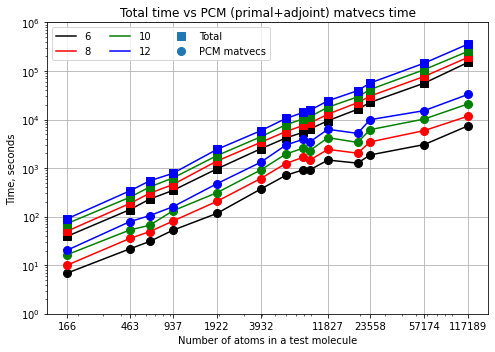

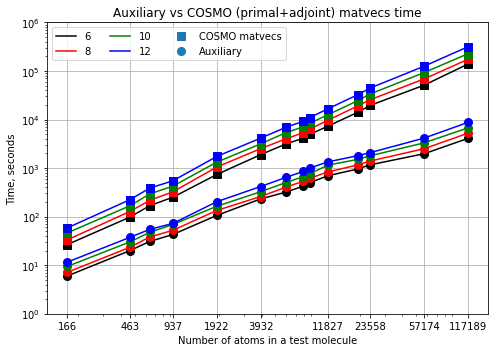

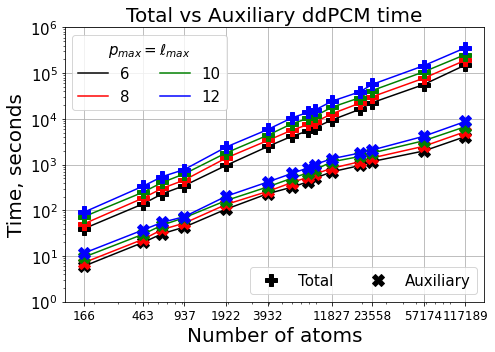

In [11]:
# Performance of PCM vs COSMO for large scale runs with pmax=lmax
# Possible values of lmax
lmaxs = [6, 8, 10, 12]
# Set of styles
styles = {6: {"color": "black"},
          8: {"color": "red"},
          10: {"color": "green"},
          12: {"color": "blue"}}
# List small molecules in a proper order (increasing number of atoms)
small_molecules = ["2rvd_sas", "2mlt_monomer_sas", "1ejg_sas", "2mlt_sas", "2qho_a_sas",
             "2qho_ab_sas", "2qho_abc_sas", "2qho_abcd_sas", "2qho_sas",
             "2gx2_sas", "waterglobe_sas", "dhfr_sas"]
# List big molecules (they are in different directory)
big_molecules = ["50k_sas", "100k_sas"]
# Number of atoms in molecules
natoms = np.array([166, 463, 642, 937, 1922, 3932, 5941, 7887, 8799, 11827, 19200, 23558, 57174, 117189])
# Xticks
xticks = np.array([166, 463, 937, 1922, 3932, 11827, 23558, 57174, 117189])
# Prepare plot
fig_pcm, ax_pcm = plt.subplots(figsize=(7, 5))
fig_cosmo, ax_cosmo = plt.subplots(figsize=(7, 5))
fig, ax = plt.subplots(figsize=(7, 5))
# Generate plots
for lmax in lmaxs:
    pmax = lmax
    pcm_time = []
    cosmo_time = []
    total_time = []
    aux_time = []
    # At first read small runs
    for mol in small_molecules:
        # Read file with a given pmax
        fname_fmm = "../experiments/fmm_vs_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
        result_fmm = read_output_file(fname_fmm)
        pcm_time.append(result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"])
        cosmo_time.append(result_fmm["ddcosmo step time"]+result_fmm["adjoint ddcosmo step time"])
        total_time.append(result_fmm["ddpcm time"])
        aux_time.append(total_time[-1]-pcm_time[-1]-cosmo_time[-1])
    # Now read big runs
    for mol in big_molecules:
        # Read file with a given pmax
        fname_fmm = "../experiments/large_fmm_sas/{}.{}.{}.fmm".format(mol, lmax, pmax)
        result_fmm = read_output_file(fname_fmm)
        pcm_time.append(result_fmm["ddpcm step time"]+result_fmm["adjoint ddpcm step time"])
        cosmo_time.append(result_fmm["ddcosmo step time"]+result_fmm["adjoint ddcosmo step time"])
        total_time.append(result_fmm["ddpcm time"])
        aux_time.append(total_time[-1]-pcm_time[-1]-cosmo_time[-1])
    ax_pcm.loglog(natoms, total_time, label="Total, $p_{{max}}=\ell_{{max}}={}$".format(lmax), markersize=8, marker="s",
              linestyle="-", **styles[lmax])
    ax_pcm.loglog(natoms, pcm_time, label="PCM, $p_{{max}}=\ell_{{max}}={}$".format(lmax), markersize=8,
              marker="o", linestyle="-", **styles[lmax])
    ax_cosmo.loglog(natoms, cosmo_time, label="COSMO, $\ell_{{max}}={}$".format(lmax), markersize=8,
              marker="s", linestyle="-", **styles[lmax])
    ax_cosmo.loglog(natoms, aux_time, label="Aux, $p_{{max}}=\ell_{{max}}={}$".format(lmax), markersize=8,
              marker="o", linestyle="-", **styles[lmax])
    ax.loglog(natoms, total_time, label="Total, $p_{{max}}=\ell_{{max}}={}$".format(lmax), markersize=12,
              marker="P", linestyle="-", **styles[lmax])
    ax.loglog(natoms, aux_time, label="Aux, $p_{{max}}=\ell_{{max}}={}$".format(lmax), markersize=12,
              marker="X", linestyle="-", **styles[lmax])
# Append legend data for different pmax
pcm_handles = []
cosmo_handles = []
handles1 = []
for lmax in lmaxs:
    # Create a proxy line to add to the legend
    line = mpl.lines.Line2D([], [], label="{}".format(lmax), linestyle="-", **styles[lmax])
    pcm_handles.append(line)
    cosmo_handles.append(line)
    handles1.append(line)
line = mpl.lines.Line2D([], [], label="Total", markersize=8, marker="s", linestyle="")
pcm_handles.append(line)
line = mpl.lines.Line2D([], [], label="PCM matvecs", markersize=8, marker="o", linestyle="")
pcm_handles.append(line)
line = mpl.lines.Line2D([], [], label="COSMO matvecs", markersize=8, marker="s", linestyle="")
cosmo_handles.append(line)
line = mpl.lines.Line2D([], [], label="Auxiliary", markersize=8, marker="o", linestyle="")
cosmo_handles.append(line)
line = mpl.lines.Line2D([], [], label="Total", markersize=12, marker="P", color="black", linestyle="")
handles2 = [line]
line = mpl.lines.Line2D([], [], label="Auxiliary", markersize=12, marker="X", color="black", linestyle="")
handles2.append(line)
ax_pcm.grid()
ax_cosmo.grid()
ax.grid()
ax_pcm.set_xlabel("Number of atoms in a test molecule")
ax_cosmo.set_xlabel("Number of atoms in a test molecule")
ax.set_xlabel("Number of atoms", fontsize=20)
ax_pcm.set_ylabel("Time, seconds")
ax_cosmo.set_ylabel("Time, seconds")
ax.set_ylabel("Time, seconds", fontsize=20)
ax_pcm.set_title("Total time vs PCM (primal+adjoint) matvecs time")
ax_cosmo.set_title("Auxiliary vs COSMO (primal+adjoint) matvecs time")
ax.set_title("Total vs Auxiliary ddPCM time", fontsize=20)
ax_pcm.set_xticks(xticks)
ax_cosmo.set_xticks(xticks)
ax.set_xticks(xticks)
ax_pcm.set_xticklabels(xticks)
ax_cosmo.set_xticklabels(xticks)
ax.set_xticklabels(xticks, fontsize=12)
ax_pcm.set_ylim([1e0, 1e6])
ax_cosmo.set_ylim([1e0, 1e6])
ax.set_ylim([1e0, 1e6])
ax.tick_params(axis="y", labelsize=15)
ax_pcm.legend(handles=pcm_handles, ncol=3)
ax_cosmo.legend(handles=cosmo_handles, ncol=3)
legend1 = ax.legend(loc="upper left", handles=handles1, ncol=2, fontsize=15)
legend1.set_title("$p_{{max}}=\ell_{{max}}$", prop={"size": 15})
legend2 = ax.legend(loc="lower right", handles=handles2, ncol=2, fontsize=15)
ax.add_artist(legend1)
fig_pcm.tight_layout()
fig_cosmo.tight_layout()
fig.tight_layout()
#fig_pcm.savefig("fmm_sas_time.pgf")
#fig_cosmo.savefig("fmm_sas_cosmo_scale.pgf")
fig.savefig("fmm_sas_time.pgf")
plt.show()